# CITS5017 Deep Learning - Project 2
**Semester 2, 2024**  
**Assessed, Worth 20%**  
**Due Date:** Friday, 18th October 2024, 11:59 PM (Special Consideration Extension: Friday, 25th October 2024, 11:59 PM)

---

## Table of Contents
1. [Project Tasks](#Introduction)
2. [Dataset Overview and Preparation](#dataset-overview-and-preparation)
3. [Task Part (i): Temperature Prediction Models](#task-part-i-temperature-prediction-models)
    - [a. Data Splitting](#a-data-splitting)
    - [b. Visualization Function](#b-visualization-function)
    - [c. Model 1: Two-Layered GRU Network](#c-model-1-two-layered-gru-network)
    - [d. Model 2: GRU Network for One-Month Prediction](#d-model-2-gru-network-for-one-month-prediction)
    - [e. Model 3: GRU Encoder-Decoder Network](#e-model-3-gru-encoder-decoder-network)
    - [f. Model Comparison Across Different Target Lengths](#f-model-comparison-across-different-target-lengths)
4. [Task Part (ii): Variational Autoencoder for Temperature Synthesis](#task-part-ii-variational-autoencoder-for-temperature-synthesis)
    - [a. VAE Architecture](#a-vae-architecture)
    - [b. Training the VAE](#b-training-the-vae)
    - [c. Evaluating the VAE](#c-evaluating-the-vae)

---

<a id='Introduction'></a>
## 1. Project Tasks

1. **Temperature Prediction Models**: Implement three distinct algorithms to predict minimum and maximum monthly temperatures. Compare their performances to identify the most effective model.
2. **Variational Autoencoder (VAE)**: Train a VAE to synthesize realistic temperature sequences, focusing on the maximum temperatures.

---

<a id='dataset-overview-and-preparation'></a>
## 2. Dataset Overview and Preparation

### Data Sources

The project utilizes temperature data from two weather stations in Western Australia:

- **Perth Airport (Station No. 009021)**: Serves as the reference station with temperature records from June 1944 to August 2024 (963 months).
- **Perth Metro (Station No. 009225)**: Located approximately 9.77 km from Perth Airport, with temperature records from January 1994 to August 2024 (368 months).

### Data Loading

The temperature data is provided in a pickle file named `temperatures.pkl`. The following function is used to load the data:

In [1]:
import pickle
import pandas as pd

NUM_FEATURES = 2 # minimum and maximum temp

# Function to load data
def load_data(picklefile):
    f = open(picklefile, "rb")
    dict = pickle.load(f)
    f.close()
    return dict["Perth_Airport"], dict["Perth_Metro"]
PerthA_df, PerthM_df = load_data("temperatures.pkl")

In [2]:
PerthA_df.columns = ["min", "max"] #renaming column for easy of use
PerthM_df.columns = ["min", "max"]

In [3]:
def split_data(df, inputs_length, targets_length, batch_size=32, shuffle=True, seed=42):
    # an inner function to do the splitting
    def split_inputs_and_targets(tf_ds):
        return tf_ds[:, :-targets_length], tf_ds[:, -targets_length:]
    if batch_size == -1:
        batch_size = df.shape[0]
    return tf.keras.utils.timeseries_dataset_from_array(
        tf.convert_to_tensor(df, dtype=tf.float32),
        targets = None,
        sequence_length = inputs_length + targets_length,
        batch_size = batch_size,
        shuffle = shuffle,
        seed = seed
    ).map(split_inputs_and_targets)

<a id='task-part-i-temperature-prediction-models'></a>
## 3. Task Part (i): Temperature Prediction Models

<a id='a-data-splitting'></a>
### a. Data Splitting

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the training data
PerthA_scaled = scaler.fit_transform(PerthA_df)
PerthA_df_scaled = pd.DataFrame(PerthA_scaled, index=PerthA_df.index, columns=PerthA_df.columns)

# Apply the same transformation to validation and test data
PerthM_scaled = scaler.transform(PerthM_df)
PerthM_df_scaled = pd.DataFrame(PerthM_scaled, index=PerthM_df.index, columns=PerthM_df.columns)

In [6]:
def prepare_datasets(inputs_length, targets_length, batch_size_train=32, model_type='model1'):
    """
    Prepares training, validation, and test datasets with specified input and target lengths.

    Parameters:
    - inputs_length: Length of input sequences.
    - targets_length: Length of target sequences.
    - batch_size_train: Batch size for the training dataset.
    - model_type: 'model1' for Models 1 and 2, 'model3' for the Encoder-Decoder model.

    Returns:
    - train_ds, val_ds, test_ds: TensorFlow datasets.
    """
    # Select the appropriate data preparation function based on model_type
    if model_type == 'model1':
        split_fn = split_data  # For Models 1 and 2
    elif model_type == 'model3':
        split_fn = prepare_encoder_decoder_data_internal  # For Model 3
    else:
        raise ValueError("Invalid model_type. Use 'model1' or 'model3'.")

    # Training dataset
    train_ds = split_fn(
        df=PerthA_df_scaled,
        inputs_length=inputs_length,
        targets_length=targets_length,
        batch_size=batch_size_train,
        shuffle=True,
        seed=42
    )

    # Validation dataset
    val_ds = split_fn(
        df=PerthM_df_scaled.loc['1994-01':'2013-12'],
        inputs_length=inputs_length,
        targets_length=targets_length,
        batch_size=-1,
        shuffle=False
    )

    # Test dataset
    test_ds = split_fn(
        df=PerthM_df_scaled.loc['2014-01':],
        inputs_length=inputs_length,
        targets_length=targets_length,
        batch_size=-1,
        shuffle=False
    )

    return train_ds, val_ds, test_ds

In [7]:
# Define input shape
input_length = 72
target_length = 12
train_ds, val_ds, test_ds = prepare_datasets(input_length, target_length)

<a id='b-visualization-function'></a>
### b. Visualization Function

In [8]:
def display_temperatures(X, y, model_name='', predicted=None, title_prefix='', inverse_scaler=None):
    """
    Displays temperature sequences from inputs and targets (and optionally predictions).
    
    Parameters:
    - X: NumPy array of input sequences, shape (num_sequences, input_length, NUM_FEATURES).
    - y: NumPy array of target sequences, shape (num_sequences, target_length, NUM_FEATURES).
    - predicted: (Optional) NumPy array of predicted sequences, same shape as y.
    - title_prefix: (Optional) Prefix for subplot titles.
    - inverse_scaler: (Optional) Scaler object with inverse_transform method to revert scaling.
    """
    num_sequences = X.shape[0]
    indices = random.sample(range(num_sequences), 3)   #choose 3 randomly sampled sequences
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    
    for i, idx in enumerate(indices):
        ax = axes[i]
        # Combine input and target sequences for plotting
        input_seq = X[idx]
        target_seq = y[idx]
        if predicted is not None:
            predicted_seq = predicted[idx]
        else:
            predicted_seq = None

        # Optionally inverse transform the data
        if inverse_scaler is not None:
            input_seq_full = np.concatenate([input_seq, target_seq], axis=0)
            input_seq_full = inverse_scaler.inverse_transform(input_seq_full)
            input_seq = input_seq_full[:len(input_seq)]
            target_seq = input_seq_full[len(input_seq):len(input_seq) + len(target_seq)]
            if predicted_seq is not None:
                predicted_seq_full = np.concatenate([input_seq, predicted_seq], axis=0)
                predicted_seq_full = inverse_scaler.inverse_transform(predicted_seq_full)
                predicted_seq = predicted_seq_full[len(input_seq):len(input_seq) + len(predicted_seq)]
        
        # Time axes
        input_time = np.arange(len(input_seq))
        target_time = np.arange(len(input_seq), len(input_seq) + len(target_seq))
        
        # Plot minimum temperatures
        ax.plot(input_time, input_seq[:, 0], label='Input Min Temp', color='blue')
        if len(target_seq) > 1:
            ax.plot(target_time, target_seq[:, 0], label='Target Min Temp', color='cyan')
        else:
            ax.plot(target_time, target_seq[:, 0], 'o', label='Target Min Temp', color='cyan')
        if predicted_seq is not None:
            if len(predicted_seq) > 1:
                ax.plot(target_time, predicted_seq[:, 0], label='Predicted Min Temp', linestyle='--', color='navy')
            else:
                ax.plot(target_time, predicted_seq[:, 0], 'x', label='Predicted Min Temp', color='navy', markersize=8)
        
        # Plot maximum temperatures
        ax.plot(input_time, input_seq[:, 1], label='Input Max Temp', color='red')
        if len(target_seq) > 1:
            ax.plot(target_time, target_seq[:, 1], label='Target Max Temp', color='orange')
        else:
            ax.plot(target_time, target_seq[:, 1], 'o', label='Target Max Temp', color='orange')
        if predicted_seq is not None:
            if len(predicted_seq) > 1:
                ax.plot(target_time, predicted_seq[:, 1], label='Predicted Max Temp', linestyle='--', color='darkred')
            else:
                ax.plot(target_time, predicted_seq[:, 1], 'x', label='Predicted Max Temp', color='darkred', markersize=8)
        
        ax.set_title(f'{model_name} {title_prefix} Sequence {idx}')
        ax.set_xlabel('Time (Months)')
        if i == 0:
            ax.set_ylabel('Temperature')
            ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

2024-10-26 02:09:12.028590: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


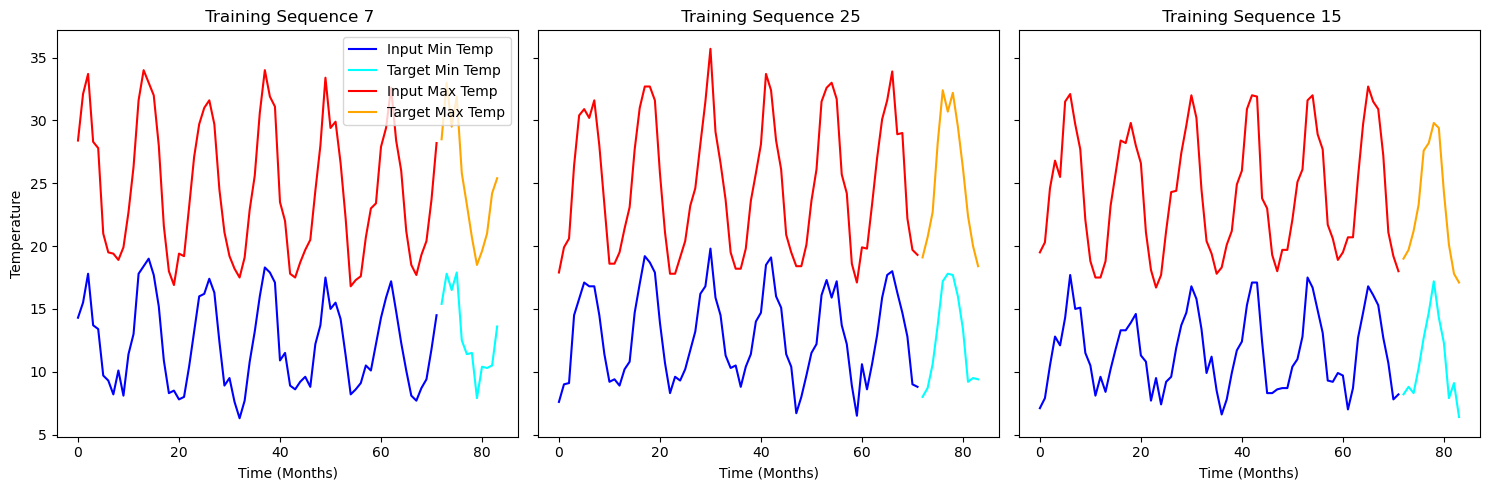

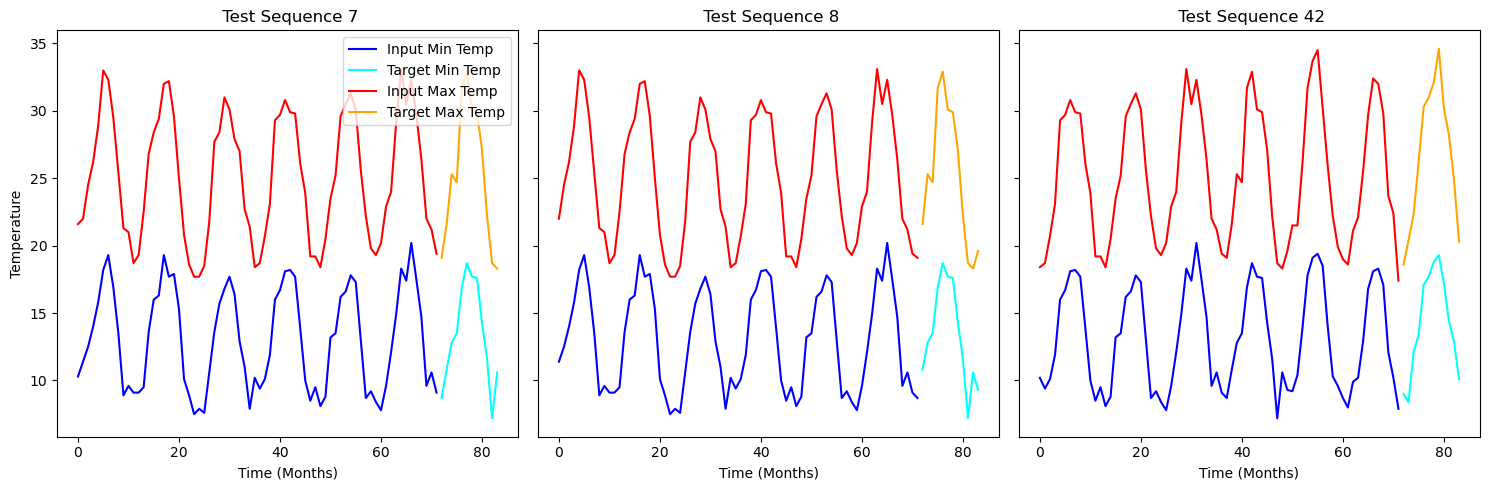

In [9]:
# Example usage with training data
for X_train_batch, y_train_batch in train_ds.take(1):
    display_temperatures(X_train_batch, y_train_batch, title_prefix='Training', inverse_scaler=scaler)

# Example usage with test data
for X_test_batch, y_test_batch in test_ds.take(1):
    display_temperatures(X_test_batch, y_test_batch, title_prefix='Test', inverse_scaler=scaler)


<a id='c-model-1-two-layered-gru-network'></a>
### c. Implementation of Model 1: Two-Layered GRU Network all in one go

Here we implement a two-layered GRU network that would learn the minimum and maximum temperature patterns of 72 months and predict the following 12 months’ minimum and maximum temperatures all in one go.

First, import necessary layers to build the model

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Reshape

In [11]:
def build_model1(input_shape, target_length):
    """
    Build the model that learns min and max temperature patterns in one go

    Parameters:
    - input_shape: length of input sequence
    - target_length: length of target sequence
    Returns:
    - model
    """
    inputs = Input(shape=input_shape)
    gru1 = GRU(16, return_sequences=True, activation='relu')(inputs)
    gru2 = GRU(16, activation='relu')(gru1)
    outputs = Dense(target_length * input_shape[1])(gru2)
    outputs = Reshape((target_length, input_shape[1]))(outputs)
    model = Model(inputs, outputs, name='Model1')
    model.compile(optimizer='adam', loss='mae', metrics=['mae']) # we use adam optimiser here
    return model


We modularise a model.fit() function below that would train the model with selected train and validation datasets, and plots learning curves

In [12]:
def train_model(model, train_ds, val_ds, epochs=50, isCompare=False, verbose=0):
    """
    Trains the model and plots learning curves.

    Parameters:
    - model: Compiled TensorFlow model.
    - train_ds: Training dataset.
    - val_ds: Validation dataset.
    - epochs: Number of epochs to train.
    - isCompare: Do not show learning curves if its Task F, else show learning curves

    Returns:
    - history: Training history object.
    """
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        verbose=verbose
    )

    # Only for task (f)
    if isCompare==False:
        # Plot learning curves
        plt.figure(figsize=(8, 5))
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.legend()
        plt.title(f'Learning Curves for {model.name}')
        plt.show()

    return history


The `evaluate_and_visualize` function assesses a trained model's performance on a test dataset by generating predictions, computing the Mean Absolute Error (MAE) between these predictions and the actual target sequences, and visualizing the results. It accommodates different model types by adjusting the prediction approach accordingly, performs inverse scaling to restore original temperature values, and utilizes the `display_temperatures` function to plot input sequences alongside predicted and true targets.

In [13]:
def evaluate_and_visualize(model, test_ds, model_type='model1', target_length=None, isCompare=False):
    """
    Evaluates the model on the test set and visualizes predictions.

    Parameters:
    - model: Trained model.
    - test_ds: Test dataset.
    - model_type: Type of the model ('model1', 'model2', 'model3', 'model2b').
    - target_length: Length of the target sequence (needed for Model 3).

    Returns:
    - test_mae: MAE on the test set.
    """
    # Initialize variables
    y_pred = None

    if model_type == 'model3':
        # Prepare inference models
        encoder_model, decoder_model = build_inference_models(model)

        # Extract encoder inputs and decoder targets from the test dataset
        encoder_inputs_test = []
        decoder_targets_test = []
        for inputs, decoder_target_data in test_ds:
            encoder_input_data, decoder_input_data = inputs
            encoder_inputs_test.append(encoder_input_data.numpy())
            decoder_targets_test.append(decoder_target_data.numpy())
        encoder_inputs_test = np.concatenate(encoder_inputs_test, axis=0)
        decoder_targets_test = np.concatenate(decoder_targets_test, axis=0)

        # Make predictions
        y_pred = decode_sequence(encoder_inputs_test, encoder_model, decoder_model, target_length)
        y_test = decoder_targets_test
        X_test = encoder_inputs_test

    else:
        # For model1 and model2
        for X_test, y_test in test_ds.take(1):
            pass  # just to obtain X_test and y_test 

        # Convert X_test and y_test to NumPy arrays if they are tensors
        X_test = X_test.numpy() if isinstance(X_test, tf.Tensor) else X_test
        y_test = y_test.numpy() if isinstance(y_test, tf.Tensor) else y_test

        if model_type == 'model2b':    #predict 12 months min and max temp using for loop
            # Predict one step ahead in a loop for the target sequence length
            target_length = y_test.shape[1]
            y_preds = []
            X_input = X_test.copy()
            for _ in range(target_length):
                y_pred_step = model.predict(X_input)
                y_pred_step = y_pred_step.reshape(-1, 1, X_input.shape[2])
                y_preds.append(y_pred_step)
                # Update X_input by removing the first time step and appending y_pred_step
                X_input = np.concatenate([X_input[:, 1:, :], y_pred_step], axis=1)
            y_pred = np.concatenate(y_preds, axis=1)
        else:
            # Direct prediction
            y_pred = model.predict(X_test)
            y_pred = y_pred.reshape(y_test.shape)

    # Inverse transform y_pred and y_test to original scale
    # Reshape y_pred and y_test to 2D arrays for inverse_transform
    y_pred_reshaped = y_pred.reshape(-1, NUM_FEATURES)
    y_test_reshaped = y_test.reshape(-1, NUM_FEATURES)

    # Inverse transform
    y_pred_original = scaler.inverse_transform(y_pred_reshaped)
    y_test_original = scaler.inverse_transform(y_test_reshaped)

    # Reshape back to original shape
    y_pred_original = y_pred_original.reshape(y_pred.shape)
    y_test_original = y_test_original.reshape(y_test.shape)

    # Evaluate MAE on original scale
    test_mae = np.mean(np.abs(y_test_original - y_pred_original))
    print(f"Test MAE: {test_mae:.4f}")

    # Visualize predictions if not task (f)
    if isCompare==False:
        display_temperatures(X_test, y_test, predicted=y_pred, title_prefix=f'Test Predictions ({model.name})', inverse_scaler=scaler)

    return test_mae


After all function is defined, now we can build, fit, and evaluate the first model

In [14]:
# Get input shape from the dataset
for X_batch, y_batch in train_ds.take(1):
    input_shape = X_batch.shape[1:]  # (input_length, num_features)
    
# Build the model
model1 = build_model1(input_shape, target_length)

# Illustrate the architecture
model1.summary()

Model: "Model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 72, 2)]           0         
                                                                 
 gru (GRU)                   (None, 72, 16)            960       
                                                                 
 gru_1 (GRU)                 (None, 16)                1632      
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 reshape (Reshape)           (None, 12, 2)             0         
                                                                 
Total params: 3,000
Trainable params: 3,000
Non-trainable params: 0
_________________________________________________________________


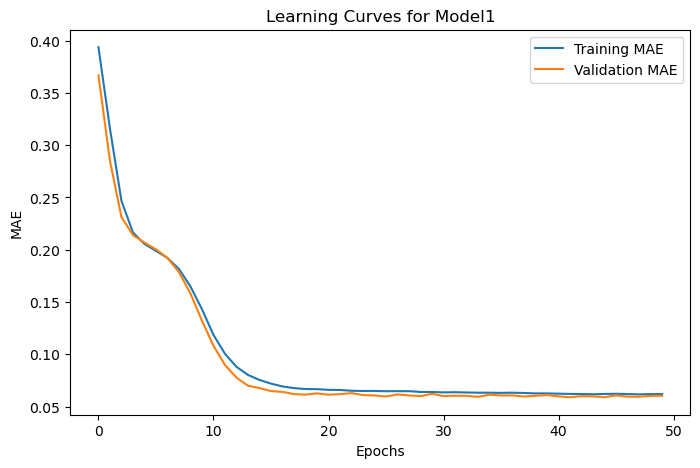

In [15]:
# Train the model
history1 = train_model(model1, train_ds, val_ds, epochs=50, verbose=0)

2/2 [==============================] - 0s 8ms/step
Test MAE: 1.1976


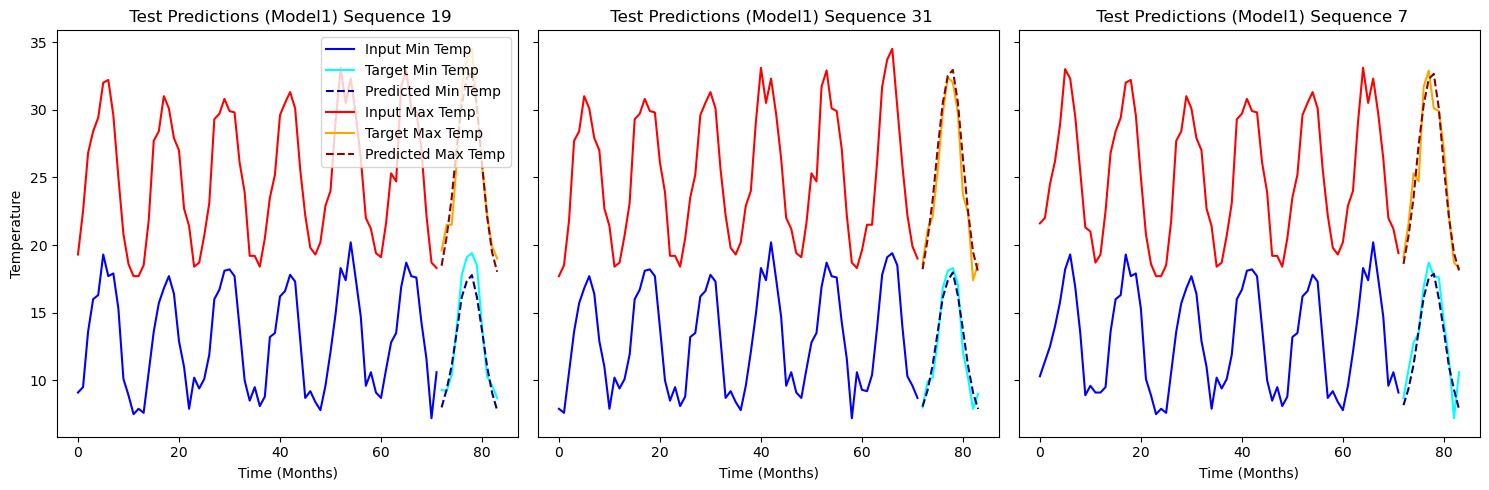

In [16]:
# Evaluate the model on the test dataset and display_temperature (built in side)
test_mae1 = evaluate_and_visualize(model1, test_ds, model_type='model1')

<a id='d-model-2-gru-network-for-one-month-prediction'></a>
### d. Implementation of Model 2: GRU Network for One-Month Prediction

Similarly, we implement a two-layered GRU network that would learn the minimum and maximum temperature patterns of 72 months and predict the following 1 month's minimum and maximum temperatures. The difference in the model building, we are using 1 as `target_length`

In [17]:
# Build Model 2
def build_model2(input_shape):
    """
    Build the model that learns the following months' min and max temperature patterns 

    Parameters:
    - input_shape: length of input sequence
    - target_length: length of target sequence
    Returns:
    - model
    """
    inputs = Input(shape=input_shape)

    # Encoder
    gru1 = GRU(16, return_sequences=True, activation='tanh')(inputs)
    gru2 = GRU(16, activation='tanh')(gru1)

    # Output layer: Predicting 1 time step ahead
    outputs = Dense(input_shape[1])(gru2)   # Output shape: (batch_size, NUM_FEATURES)
    outputs = Reshape((1, NUM_FEATURES))(outputs)  # Output shape: (batch_size, 1, NUM_FEATURES)

    model = Model(inputs, outputs, name=f'Model2')
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])
    return model

Call `split_data` (in our case it's modularised in `prepare_datasets`) to get the datasets for this model, keeping in mind `target_length=1`, then repeat subtasks

In [18]:
# Define input shape
input_length_model2 = 72
target_length_model2 = 1

# Prepare datasets
train_ds_model2, val_ds_model2, test_ds_model2 = prepare_datasets(input_length_model2, target_length_model2)
      
# Get input shape from the dataset
for X_batch, y_batch in train_ds_model2.take(1):
    input_shape_model2 = X_batch.shape[1:]  # (input_length, NUM_FEATURES)

# Build the model
model2 = build_model2(input_shape_model2)

# Illustrate the architecture
model2.summary()


Model: "Model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 72, 2)]           0         
                                                                 
 gru_2 (GRU)                 (None, 72, 16)            960       
                                                                 
 gru_3 (GRU)                 (None, 16)                1632      
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
 reshape_1 (Reshape)         (None, 1, 2)              0         
                                                                 
Total params: 2,626
Trainable params: 2,626
Non-trainable params: 0
_________________________________________________________________


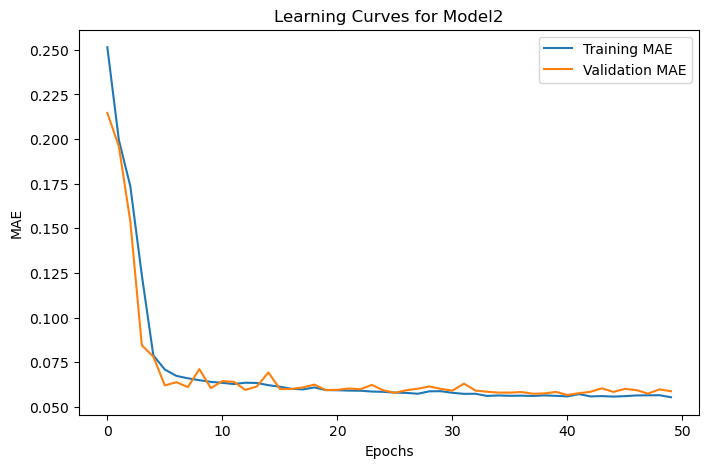

In [19]:
# Train the model 2
history2 = train_model(model2, train_ds_model2, val_ds_model2, epochs=50)

2/2 [==============================] - 0s 7ms/step
Test MAE: 1.1415


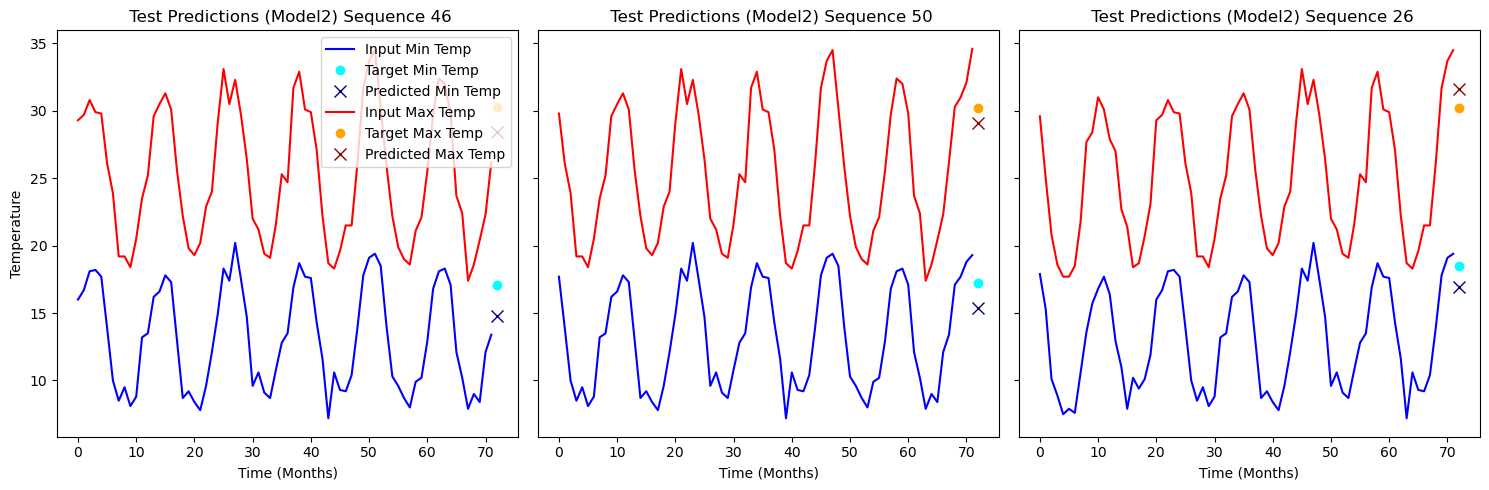

In [20]:
# Evaluate the model on the test dataset
test_mae2 = evaluate_and_visualize(model2, test_ds_model2, model_type='model2a')

The plot above shows has `o` as labels for the ground truth min and max temperature for the following month, while `x` as label for the predicted min and max temp for the following month

**Subtask 2b**: predict 12 months’ minimum and maximum
temperatures using a for loop

The for loop is implemented in `evaluate_and_visualise`

For this subtask, we used the test_ds from Model 1 as the relative ground truth as its target length is 12. We can see this illustration with `display_temperature` too below

2/2 [==============================] - 0s 5ms/step
Test MAE: 1.2944


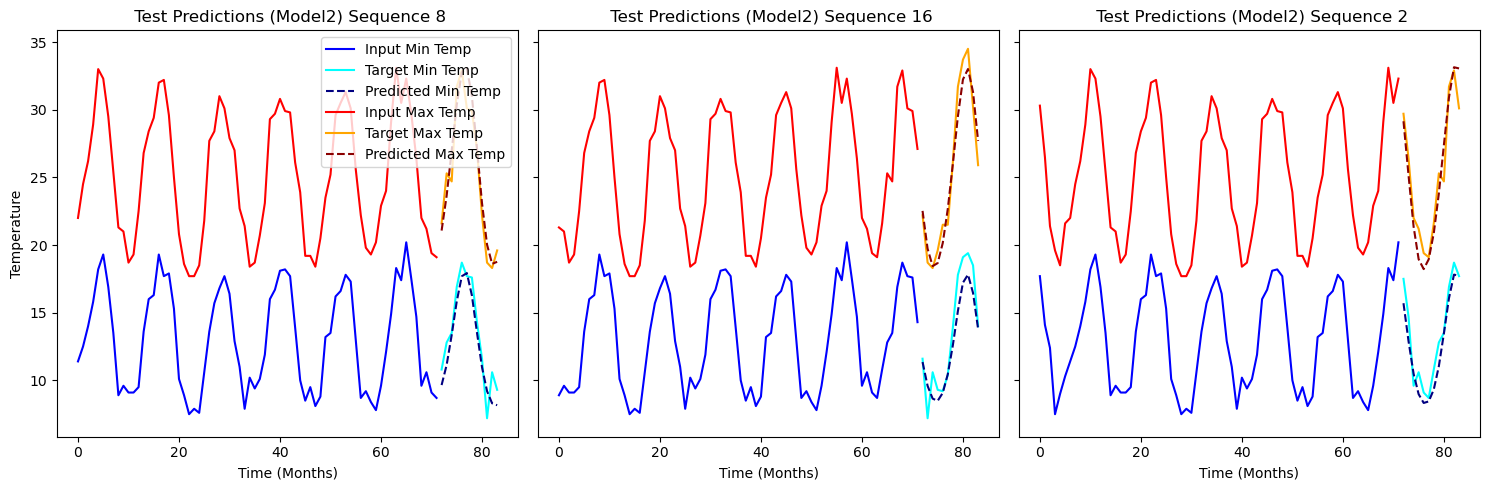

In [21]:
# Evaluate Model 2 on test_ds from Model 1
test_mae2_extended = evaluate_and_visualize(model2, test_ds, model_type='model2b')

<a id='e-model-3-gru-encoder-decoder-network'></a>
### e. Implementation of Model 3: GRU Encoder-Decoder Network

Next up, we implemented the EncoderDecoder GRU network for 12 month's prediction.

We utitlise the same `prepare_data` function, however we define a different split function for model 3 (see below), where as model 1 and 2 used the given `split_data` function.

The `prepare_encoder_decoder_data_internal` function transforms a temperature DataFrame into a TensorFlow dataset tailored for an Encoder-Decoder model. It segments each sequence into encoder inputs and decoder targets based on specified input and target lengths, constructs decoder inputs by appending a start token from the last encoder input time step, and organizes the data into batches with options for shuffling and setting a random seed. The resulting dataset yields tuples of `((encoder_input, decoder_input), decoder_target)`

In [22]:
def prepare_encoder_decoder_data_internal(df, inputs_length, targets_length, batch_size=32, shuffle=True, seed=42):
    """
    Internal function to prepare data for the Encoder-Decoder model.

    Parameters:
    - df: DataFrame containing the temperature data.
    - inputs_length: Length of input sequences for the Encoder.
    - targets_length: Length of target sequences for the Decoder.
    - batch_size: Batch size for the dataset.

    Returns:
    - dataset: TensorFlow dataset yielding ((encoder_input, decoder_input), decoder_target) tuples.
    """
    def split_encoder_decoder(sequence):
        encoder_input = sequence[:, :inputs_length, :]
        decoder_target = sequence[:, inputs_length:, :]

        # Use the last time step of encoder input as start token
        start_token = encoder_input[:, -1:, :]
        decoder_input = tf.concat([start_token, decoder_target[:, :-1, :]], axis=1)

        return (encoder_input, decoder_input), decoder_target
    if batch_size == -1:
        batch_size = df.shape[0]

    return tf.keras.utils.timeseries_dataset_from_array(
        data=df.values,
        targets=None,
        sequence_length=inputs_length + targets_length,
        sequence_stride=1,
        shuffle=shuffle,
        batch_size=batch_size,
        seed=seed
    ).map(split_encoder_decoder)


We prepare the corresponding datasets here

In [23]:
# Define input shape
input_length_model2 = 72
target_length_model2 = 12

train_ds_model3, val_ds_model3, test_ds_model3 = prepare_datasets(input_length, target_length, model_type='model3')

The `build_encoder_decoder_model` function constructs an Encoder-Decoder architecture using two GRU layers for both the encoder and decoder parts. It processes input sequences of a specified length through sequential GRU layers with 16 neurons each and 'tanh' activation. The encoder generates hidden states that are passed to the decoder, which then produces the output sequence through its own GRU layers followed by a Dense layer with linear activation. The model is compiled with the Adam optimizer and Mean Absolute Error (MAE) loss.

In [24]:
def build_encoder_decoder_model(input_length, target_length):

    # We use 'name' parameter in our layers, for accessing later in the next function below
    # Encoder
    encoder_inputs = Input(shape=(input_length, NUM_FEATURES), name='encoder_inputs')
    encoder_gru1 = GRU(16, return_sequences=True, return_state=True, activation='tanh', name='encoder_gru1')
    encoder_outputs1, state_h1 = encoder_gru1(encoder_inputs)
    encoder_gru2 = GRU(16, return_sequences=False, return_state=True, activation='tanh', name='encoder_gru2')
    encoder_outputs2, state_h2 = encoder_gru2(encoder_outputs1)
    encoder_states = [state_h1, state_h2]
    
    # Decoder
    decoder_inputs = Input(shape=(None, NUM_FEATURES), name='decoder_inputs')  
    decoder_gru1 = GRU(16, return_sequences=True, return_state=True, activation='tanh', name='decoder_gru1')
    decoder_outputs1, _ = decoder_gru1(decoder_inputs, initial_state=state_h1)
    decoder_gru2 = GRU(16, return_sequences=True, return_state=True, activation='tanh', name='decoder_gru2')
    decoder_outputs2, _ = decoder_gru2(decoder_outputs1, initial_state=state_h2)
    decoder_dense = Dense(NUM_FEATURES, activation='linear', name='decoder_dense')
    decoder_outputs = decoder_dense(decoder_outputs2)
    
    # Define the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name='Model3')
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])
    
    # Return the components needed for inference
    return model, encoder_inputs, encoder_states, decoder_inputs, decoder_gru1, decoder_gru2, decoder_dense


The `build_inference_models` function creates separate encoder and decoder models from the trained Encoder-Decoder model to facilitate the inference phase. It extracts the necessary GRU layers and states from the original model to define the encoder model, which outputs the internal states given an input sequence. The decoder model is built to accept these states along with new input tokens, enabling it to generate predictions step-by-step during inference. This separation allows for efficient sequence generation when predicting temperature sequences without retraining the entire model.

In [25]:
def build_inference_models(model):
    """
    Builds the encoder and decoder models for inference from the trained model.

    Parameters:
    - model: Trained Encoder-Decoder model.

    Returns:
    - encoder_model: Model to encode input sequences.
    - decoder_model: Model to generate output sequences during inference.
    """
    # Retrieve necessary layers and inputs from the trained model
    encoder_inputs = model.input[0]  # Encoder input
    encoder_outputs, state_h1, state_h2 = None, None, None
    decoder_inputs = model.input[1]  # Decoder input

    # Find encoder and decoder layers
    for layer in model.layers:
        if layer.name == 'encoder_gru1':
            encoder_gru1 = layer
        elif layer.name == 'encoder_gru2':
            encoder_gru2 = layer
        elif layer.name == 'decoder_gru1':
            decoder_gru1 = layer
        elif layer.name == 'decoder_gru2':
            decoder_gru2 = layer
        elif layer.name == 'decoder_dense':
            decoder_dense = layer

    # Build encoder model
    encoder_outputs1, state_h1 = encoder_gru1(encoder_inputs)
    encoder_outputs2, state_h2 = encoder_gru2(encoder_outputs1)
    encoder_states = [state_h1, state_h2]
    encoder_model = Model(encoder_inputs, encoder_states)

    # Build decoder model
    decoder_state_input_h1 = Input(shape=(16,), name='decoder_state_input_h1')
    decoder_state_input_h2 = Input(shape=(16,), name='decoder_state_input_h2')
    decoder_states_inputs = [decoder_state_input_h1, decoder_state_input_h2]

    decoder_outputs1, state_h1 = decoder_gru1(decoder_inputs, initial_state=decoder_state_input_h1)
    decoder_outputs2, state_h2 = decoder_gru2(decoder_outputs1, initial_state=decoder_state_input_h2)
    decoder_states = [state_h1, state_h2]
    decoder_outputs = decoder_dense(decoder_outputs2)

    decoder_model = Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states
    )

    return encoder_model, decoder_model


The `decode_sequence` function generates predictions for a given input sequence using the encoder and decoder inference models. It first encodes the input sequence to obtain the latent states, then initializes the decoder's input with a start token derived from the last time step of the encoder input (ie predicting temperatures for the previous months, not from the ground truth). The function iteratively generates each subsequent time step in the target sequence by feeding the previous prediction back into the decoder, updating the states accordingly. This process continues for the specified target length, resulting in a complete predicted temperature sequence that can be compared against the actual target data.

In [26]:
def decode_sequence(input_seq, encoder_model, decoder_model, target_length):
    """
    Generates predictions for the given input sequence using the encoder and decoder models.

    Parameters:
    - input_seq: Input sequence for the encoder.
    - encoder_model: Encoder model.
    - decoder_model: Decoder model.
    - target_length: Length of the target sequence to predict.

    Returns:
    - decoded_seq: Predicted target sequence.
    """
    # Encode the input as state vectors
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1
    target_seq = np.zeros((input_seq.shape[0], 1, NUM_FEATURES))
    # Use last time step of encoder input as start token
    target_seq[:, 0, :] = input_seq[:, -1, :]
    
    # Collect predictions
    decoded_seq = []
    for _ in range(target_length):
        output_tokens, h1, h2 = decoder_model.predict([target_seq] + states_value)
        
        # Append the prediction
        decoded_seq.append(output_tokens)
        
        # Update target sequence (next decoder input)
        target_seq = output_tokens  # Use the last prediction as input
        
        # Update states
        states_value = [h1, h2]
    
    decoded_seq = np.concatenate(decoded_seq, axis=1)
    return decoded_seq


After model definitions, we can continue to build the model, fit, evaluate, and visualise

In [27]:
# Build the model
model3, encoder_inputs, encoder_states, decoder_inputs, decoder_gru1, decoder_gru2, decoder_dense = build_encoder_decoder_model(input_length, target_length)

# Illustrate model architecture
model3.summary()

Model: "Model3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 72, 2)]      0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None, 2)]    0           []                               
                                                                                                  
 encoder_gru1 (GRU)             [(None, 72, 16),     960         ['encoder_inputs[0][0]']         
                                 (None, 16)]                                                      
                                                                                                  
 decoder_gru1 (GRU)             [(None, None, 16),   960         ['decoder_inputs[0][0]',    

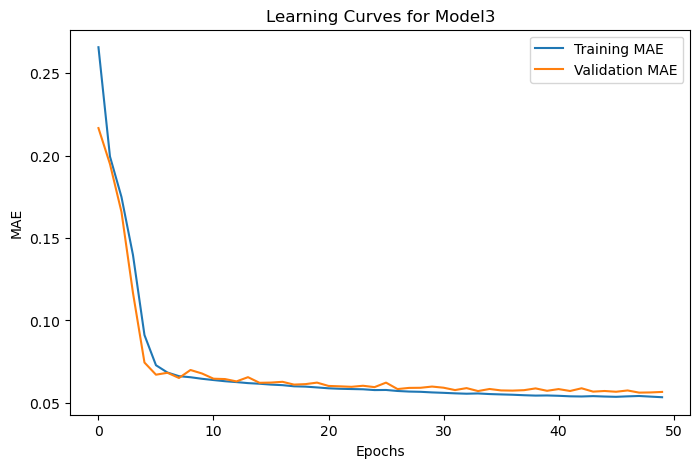

In [28]:
# Train the model
history3 = train_model(model3, train_ds_model3, val_ds_model3, epochs=50)

2/2 [==============================] - 0s 910us/step
Test MAE: 1.2278


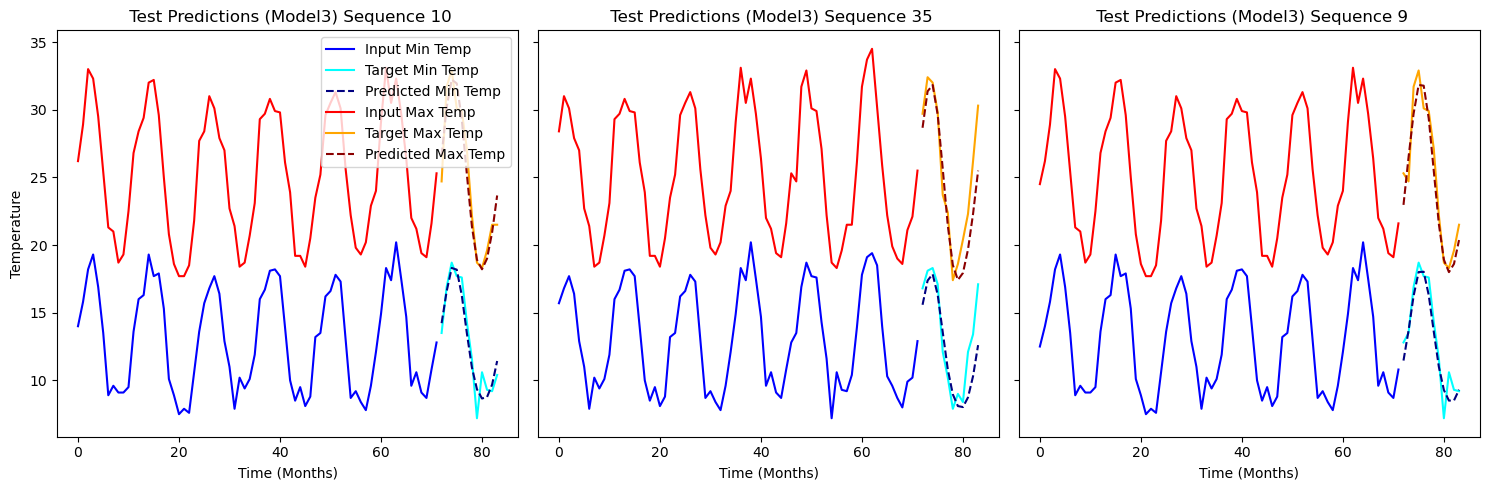

In [29]:
# Evaluate Model 3
test_mae3 = evaluate_and_visualize(model3, test_ds_model3, model_type='model3', target_length=target_length)

<a id='f-model-comparison-across-different-target-lengths'></a>
## f. Model Comparison Across Different Target Lengths


For each of the settings in `(72, 12), (66, 18), (60, 24), (54, 30), (48, 36)`, repeat the data split, training, and evaluation steps. Illustrate a MAE vs Target length plot for all 3 models

In [30]:
# Settings for input_length and target_length
settings = [
    (72, 12),
    (66, 18),
    (60, 24),
    (54, 30),
    (48, 36)
]

# Initialize dictionaries to store MAEs
mae_results = {
    'Model1': [],
    'Model2': [],
    'Model3': []
}
target_lengths = []

for input_length, target_length in settings:
    target_lengths.append(target_length)

    # Prepare datasets for Models 1 and 2
    train_ds, val_ds, test_ds = prepare_datasets(input_length, target_length)
    # Build and train Model 1
    for X_batch, y_batch in train_ds.take(1):
        input_shape_model1 = X_batch.shape[1:]
    model1 = build_model1(input_shape_model1, target_length)
    train_model(model1, train_ds, val_ds, epochs=50, isCompare=True)
    # Evaluate Model 1
    test_mae1 = evaluate_and_visualize(model1, test_ds, model_type='model1', isCompare=True)
    mae_results['Model1'].append(test_mae1)

    
    # Prepare datasets for Model 3
    train_ds_model3, val_ds_model3, test_ds_model3 = prepare_datasets(input_length, target_length, model_type='model3')
    # Build and train Model 3
    model3, _, _, _, _, _, _ = build_encoder_decoder_model(input_length, target_length)
    train_model(model3, train_ds_model3, val_ds_model3, epochs=50, isCompare=True)
    # Evaluate Model 3
    test_mae3 = evaluate_and_visualize( model3, test_ds_model3, model_type='model3', target_length=target_length, isCompare=True)
    mae_results['Model3'].append(test_mae3)

    # For Model 2, we use the existing model trained with input_length=72
    # Prepare test dataset with input_length=72 and current target_length
    _, _, test_ds_model2 = prepare_datasets(72, target_length)

    # Evaluate Model 2
    test_mae2 = evaluate_and_visualize(model2, test_ds_model2, model_type='model2b', isCompare=True)
    mae_results['Model2'].append(test_mae2)

    print("-" * 50)


2/2 [==============================] - 0s 3ms/step
Test MAE: 1.0813
2/2 [==============================] - 0s 985us/step
Test MAE: 1.1371
2/2 [==============================] - 0s 3ms/step
Test MAE: 1.2944
--------------------------------------------------
2/2 [==============================] - 0s 4ms/step
Test MAE: 1.2023
2/2 [==============================] - 0s 1ms/step
Test MAE: 1.1776
2/2 [==============================] - 0s 3ms/step
Test MAE: 1.2519
--------------------------------------------------
2/2 [==============================] - 0s 4ms/step
Test MAE: 1.1454
2/2 [==============================] - 0s 1ms/step
Test MAE: 1.1614
2/2 [==============================] - 0s 3ms/step
Test MAE: 1.2480
--------------------------------------------------
2/2 [==============================] - 0s 7ms/step
Test MAE: 1.0881
2/2 [==============================] - 0s 1ms/step
Test MAE: 1.2461
1/1 [==============================] - 0s 11ms/step
Test MAE: 1.2699
----------------------------

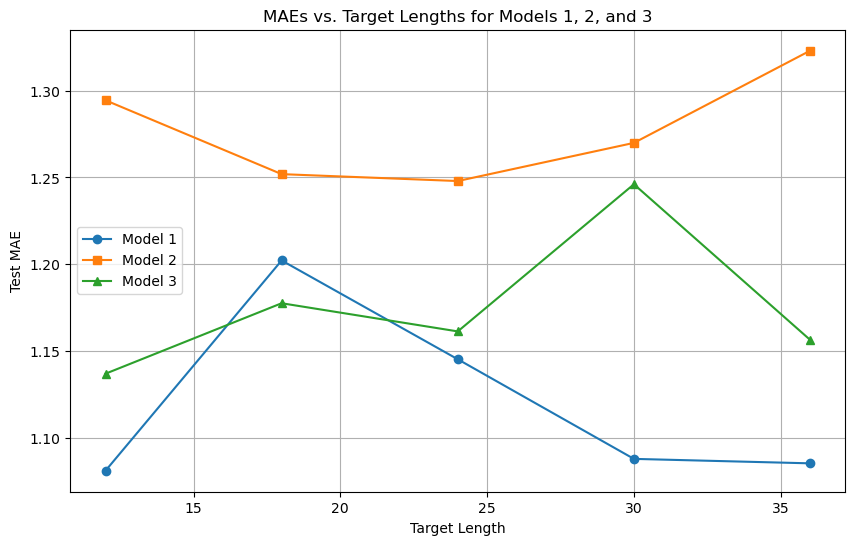

In [31]:
# Plot MAEs
plt.figure(figsize=(10, 6))
plt.plot(target_lengths, mae_results['Model1'], marker='o', label='Model 1')
plt.plot(target_lengths, mae_results['Model2'], marker='s', label='Model 2')
plt.plot(target_lengths, mae_results['Model3'], marker='^', label='Model 3')
plt.xlabel('Target Length')
plt.ylabel('Test MAE')
plt.title('MAEs vs. Target Lengths for Models 1, 2, and 3')
plt.legend()
plt.grid(True)
plt.show()


### Model Comparison: MAE vs. Target Lengths

The plot above shows the Mean Absolute Errors (MAE) for Models 1, 2, and 3 across different target lengths. Model 1 generally performs well, with a slight rise in MAE for shorter target lengths but consistently decreasing as the target length increases. Model 2 shows a relatively flat trend across most target lengths, with the lowest performance at the longest target length (36). Model 3 demonstrates a balanced performance, with moderate MAE values that rise initially but stabilize for longer target lengths.


Model 1 achieves the best performance for longer target lengths, indicating that it generalizes well as the sequence length increases. Model 2 appears less sensitive to target length but performs poorly for larger sequences. Model 3 provides an intermediate performance, handling moderate and long sequences fairly well but struggling with mid-range target lengths. Therefore, for tasks requiring longer-term predictions, Model 1 is the most robust choice, while Model 3 offers more stability across varied target lengths.


<a id='task-part-ii-variational-autoencoder-for-temperature-synthesis'></a>
## 4. Task Part (ii): Variational Autoencoder for Temperature Synthesis


### Data preprocessing

In [32]:
import tensorflow as tf
from tensorflow.keras import backend as K


# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

We take `84 months` as training input sequence from the Perth Airport dataframe, for the validation sequence we use use the Perth Metro dataframe from “1994-01” to “2013-12”, similar to that of the previous tasks.

In [33]:
train_temps = PerthA_df[['max']]
valid_temps = PerthM_df[['max']].loc['1994-01':'2013-12']

In [34]:
# Convert to DataFrame for consistency
train_temps = pd.DataFrame(train_temps, index=train_temps.index, columns=['max'])
valid_temps = pd.DataFrame(valid_temps, index=valid_temps.index, columns=['max'])

In [35]:
# Create sequences of 84 months
sequence_length = 84
batch_size = 32

def create_sequences(data, seq_length):
    X = []
    for i in range(len(data) - seq_length + 1):
        X.append(data.iloc[i:i+seq_length].values)
    return np.array(X)

# Prepare the dataset
train_sequences = create_sequences(train_temps, sequence_length)
val_sequences = create_sequences(valid_temps, sequence_length)

print(f"Sequence shape: {train_sequences.shape[1:]}")  # Should be (84, 1)

Sequence shape: (84, 1)


## VAE Model Building
We need a custom <code>Sampling</code>layer to sample the codings. This layer takes inputs <code>codings_mean</code> and <code>codings_log_var</code>, which represent parameters of the latent Gaussian distribution that samples a codings vector with mean miu and standard deviation sigma.

In [36]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        # Reparameterization trick
        epsilon = tf.random.normal(shape=tf.shape(log_var))
        return mean + tf.exp(0.5 * log_var) * epsilon


We can create the `encoder` that accepts sequences of shape <code>(84, 1)</code>. We output <code>codings</code> (for our decoder input), <code>codings_mean</code> and <code>codings_log_var</code> for report.

In [37]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Rescaling

# Define the coding size (latent dimension)
coding_size = 10

# Encoder
encoder_inputs = tf.keras.Input(shape=(sequence_length, 1))
x = layers.Rescaling(scale=1.0/40.0)(encoder_inputs)  # Assuming MaxTemp is around [0, 40] degrees Celsius
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
codings_mean = layers.Dense(coding_size, name='z_mean')(x)
codings_log_var = layers.Dense(coding_size, name='z_log_var')(x)
codings = Sampling()([codings_mean, codings_log_var])
encoder = tf.keras.Model(encoder_inputs, [codings_mean, codings_log_var, codings], name='encoder')

encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 84, 1)]      0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 84, 1)        0           ['input_8[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 84)           0           ['rescaling[0][0]']              
                                                                                                  
 dense_7 (Dense)                (None, 64)           5440        ['flatten[0][0]']                
                                                                                            

We can create the `decoder` that accepts a latent vector of shape <code>(coding_size,)</code>. The decoder processes this vector through Dense layers with ReLU activation, applies inverse scaling to restore the original temperature scale, and reshapes the output to generate reconstructed sequences of shape <code>(sequence_length, 1)</code>. The final output, <code>decoder_outputs</code>, serves as the reconstructed temperature sequence based on the latent representation.

In [38]:
# Decoder
decoder_inputs = tf.keras.Input(shape=(coding_size,))
x = layers.Dense(64, activation='relu')(decoder_inputs)
x = layers.Dense(sequence_length)(x)
x = layers.Rescaling(scale=40.0)(x)  # Inverse scaling
decoder_outputs = layers.Reshape((sequence_length, 1))(x)
decoder = tf.keras.Model(decoder_inputs, decoder_outputs, name='decoder')

decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_8 (Dense)             (None, 64)                704       
                                                                 
 dense_9 (Dense)             (None, 84)                5460      
                                                                 
 rescaling_1 (Rescaling)     (None, 84)                0         
                                                                 
 reshape_7 (Reshape)         (None, 84, 1)             0         
                                                                 
Total params: 6,164
Trainable params: 6,164
Non-trainable params: 0
_________________________________________________________________


We can create the `LossLayer` to compute the Variational Autoencoder (VAE) loss by flattening the original input <code>original_code</code> and the decoded output <code>reconstructed</code>, calculating the reconstruction loss using Mean Squared Error, and determining the Kullback-Leibler (KL) divergence based on <code>codings_mean</code> and <code>codings_log_var</code>. This layer takes in <code>original_input</code>, <code>reconstructed</code>, <code>codings_mean</code>, and <code>codings_log_var</code>, then adds the combined loss to the model while passing the original input <code>original_input</code> forward for further processing.


In [39]:
import keras
class LossLayer(keras.layers.Layer):

    def vae_loss(self, original_input, reconstructed, codings_mean, codings_log_var):
        original_input = K.flatten(original_input)
        reconstructed = K.flatten(reconstructed)
        
        # Reconstruction loss using Mean Squared Error
        recon_loss = K.mean(K.square(original_input - reconstructed), axis=-1)
        
        # KL divergence
        kl_loss = -0.5 * K.mean(
            1 + codings_log_var - K.square(codings_mean) - K.exp(codings_log_var),
            axis=-1
        )       
        return K.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        original_input, reconstructed, codings_mean, codings_log_var = inputs
        loss = self.vae_loss(original_input, reconstructed, codings_mean, codings_log_var)
        self.add_loss(loss)
        return original_input 

Now, Assembling the VAE model with custome Loss Layer

In [40]:
# VAE Model and the LossLayer with all required inputs
codings_mean, codings_log_var, codings = encoder(encoder_inputs)
reconstructions = decoder(codings)
y = LossLayer()([encoder_inputs, reconstructions, codings_mean, codings_log_var])

# Define the VAE model
vae = tf.keras.Model(encoder_inputs, y, name='VAE')
vae.summary()

Model: "VAE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 84, 1)]      0           []                               
                                                                                                  
 encoder (Functional)           [(None, 10),         6740        ['input_8[0][0]']                
                                 (None, 10),                                                      
                                 (None, 10)]                                                      
                                                                                                  
 decoder (Functional)           (None, 84, 1)        6164        ['encoder[0][2]']                
                                                                                                

Compile and fit the model!

In [41]:
vae.compile(optimizer='adam')
history = vae.fit(
    train_sequences,
    epochs=100,
    batch_size=batch_size,
    validation_data=(val_sequences, None), 
    verbose=0  # Suppress verbose output
)

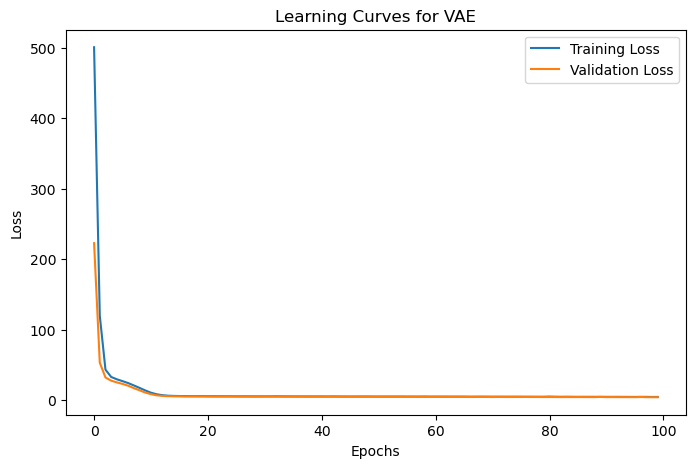

In [42]:
# Plot learning curves
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curves for VAE')
plt.show()

Here, we report the mean and logarithmic variance of the learned distributions. We utilize the trained encoder to generate the mean (`codings_mean_values`) and log variance (`codings_log_var_values`) vectors from the training sequences by performing predictions with a batch size of 32. The shapes of these vectors are printed to confirm their dimensions, and sample values are displayed to inspect the learned distribution parameters.

In [44]:
# Get the mean and log variance vectors from the encoder
codings_mean_values, codings_log_var_values, _ = encoder.predict(train_sequences, batch_size=32)

print("Mean vector shape:", codings_mean_values.shape)
print("Log variance vector shape:", codings_log_var_values.shape)
print("\nSample mean vector:")
print(codings_mean_values[0])
print("\nSample log variance vector:")
print(codings_log_var_values[0])


28/28 [==============================] - 0s 440us/step
Mean vector shape: (880, 10)
Log variance vector shape: (880, 10)

Sample mean vector:
[-1.0321215   0.27667245  0.7282154  -1.1090697  -0.10063533  0.9657054
  1.3132237   0.69024694  0.04951344  0.94214875]

Sample log variance vector:
[-4.928989  -1.5353972 -3.0797577 -5.6575685 -5.474255  -6.466775
 -5.735265  -4.932898  -2.2041984 -3.955373 ]


1/1 [==============================] - 0s 33ms/step


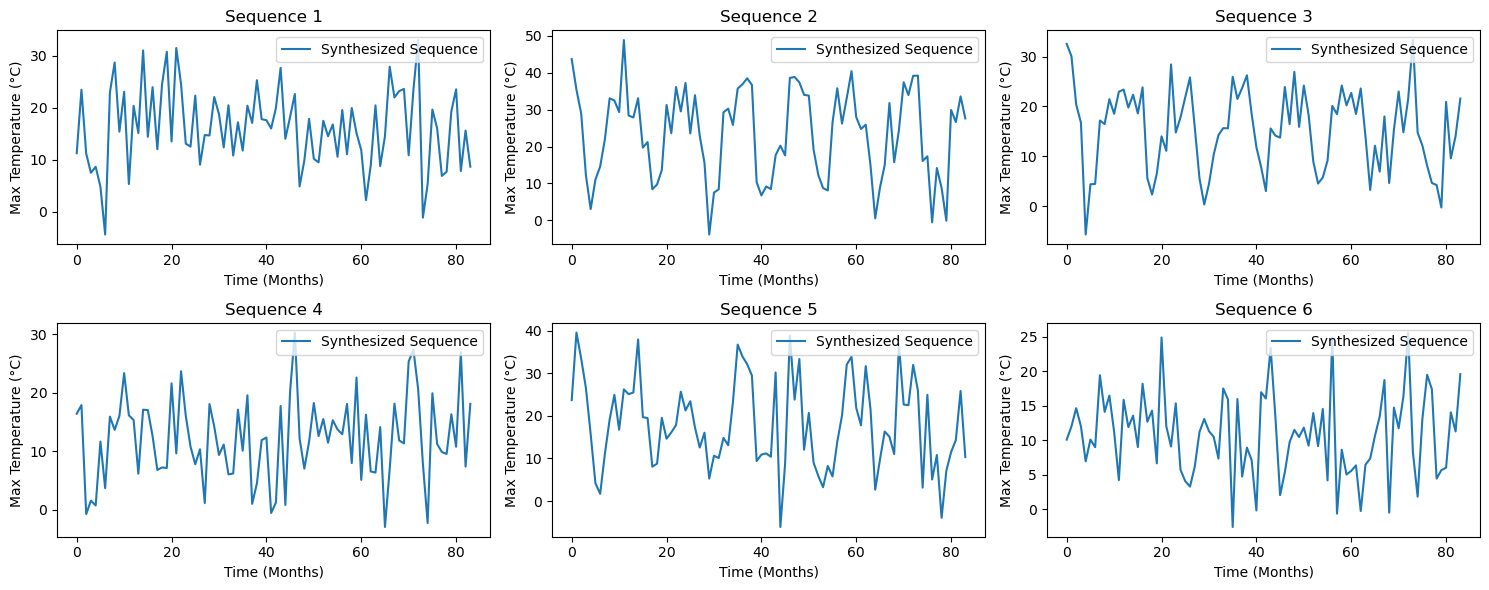

In [45]:
# Sample 6 random coding vectors from standard normal distribution
num_samples = 6
random_codings = np.random.normal(size=(num_samples, coding_size))

# Generate synthesized sequences
generated_sequences = decoder.predict(random_codings)
# Reshape the sequences to original scale
generated_sequences = generated_sequences.reshape(num_samples, sequence_length)

# Plot the synthesized sequences
fig, axes = plt.subplots(2, 3, figsize=(15, 6))
axes = axes.flatten()
for i in range(num_samples):
    axes[i].plot(generated_sequences[i], label='Synthesized Sequence')
    axes[i].set_title(f'Sequence {i+1}')
    axes[i].set_xlabel('Time (Months)')
    axes[i].set_ylabel('Max Temperature (°C)')
    axes[i].legend(loc="upper right")
plt.tight_layout()
plt.show()
